# CartPole Game using DQN

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [2]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  #!pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  #!pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents
  #Added for gym for dependency fix and pyglet bug fix
  #!pip install -q 'gym==0.21.0'
  !pip install -q 'pyglet==1.5.21'



Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# Part 12.3: Keras Q-Learning in the OpenAI Gym

Q-Learning, as we covered in the previous part, is a robust machine learning algorithm.  Unfortunately, Q-Learning requires that the Q-table contain an entry for every possible state that the environment can take.  If the environment only includes a handful of discrete state elements, then traditional Q-learning might be a good learning algorithm.  However, if the state space is large, the Q-table can become prohibitively large.

Creating policies for large state spaces is a task that Deep Q-Learning Networks (DQN) can usually handle.  Unlike a table, a neural network does not require the program to represent every combination of state and action.  Neural networks can generalize these states and learn commonalities.  A DQN maps the state to its input neurons and the action Q-values to the output neurons.  The DQN effectively becomes a function that accepts state and suggestions an action by returning the expected reward for each of the possible actions. Figure 12.DQL demonstrates the DQN structure and mapping between state and action.

**Figure 12.DQL: Deep Q-Learning (DQL)**
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/deepqlearning.png "Reinforcement Learning")




As this diagram illustrates, the environment state contains several elements.  For the basic DQN the state can be a mix of continuous and categorical/discrete values.  For the DQN, the discrete state elements the program typically encoded as dummy variables. The actions should be discrete when your program implements a DQN.  Other algorithms support continuous outputs, which we will discuss later in this chapter.

In this chapter, we will make use of [TF-Agents](https://www.tensorflow.org/agents) to implement a DQN to solve the cart-pole environment.  TF-Agents makes designing, implementing, and testing new RL algorithms easier by providing well tested modular components that can be modified and extended. It enables fast code iteration, with functional test integration and benchmarking.

## DQN and the Cart-Pole Problem

Barto (1983) first described the cart-pole problem. [[Cite:barto1983neuronlike]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) A cart is connected to a hinged rigid pole.  The cart is free to move only in the vertical plane of the cart/track.  The agent can apply an implusive "left" or "right" force F of a fixed magnitude to the cart at discrete time intervals.  The cart-pole environment simulates the physics behind keeping the pole in a reasonably upright position on the cart.  The environment has four state variables:
* $x$ The position of the cart on the track.
* $\theta$ The angle of the pole with the vertical
* $\dot{x}$ The cart velocity.
* $\dot{\theta}$ The rate of change of the angle.

The action space consists of discrete actions:
* Apply force left
* Apply force right

To apply DQN to this problem, you need to create the following components for TF-Agents.

* Environment
* Agent
* Policies
* Metrics and Evaluation
* Replay Buffer
* Data Collection
* Training

These components are standard in most DQN implementations.  Later, we will apply these same components to an Atari game, and after that, a problem of our design. This example is based on the [cart-pole tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) provided for TF-Agents.  We begin by importing needed Python libraries.


In [3]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

Several hyperparameters must be defined.  The TF-Agent example provided reasonably well-tuned hyperparameters for cart-pole.  Later we will adapt these to an Atari game.

In [5]:
# How long should training run?
#num_iterations = 20000 
# How many initial random steps, before training start, to
# collect initial data.
#initial_collect_steps = 1000   
# How many steps should we run each iteration to collect 
# data from.
#collect_steps_per_iteration = 1 
# How much data should we store for training examples.
#replay_buffer_max_length = 100000

#batch_size = 64  
#learning_rate = 1e-3 
# How often should the program provide an update.
##log_interval = 200  

# How many episodes should the program use for each evaluation.
#num_eval_episodes = 10
# How often should an evaluation occur.
#eval_interval = 1000  

# Adjusting Parameters

In [6]:
# How long should training run?
num_iterations = 10000
# How many initial random steps, before training start, to
# collect initial data.
initial_collect_steps = 10000  
# How many steps should we run each iteration to collect 
# data from.
collect_steps_per_iteration = 1
# How much data should we store for training examples.
replay_buffer_max_length = 1000000

batch_size = 64  
learning_rate = 2
# How often should the program provide an update.
log_interval = 200  

# How many episodes should the program use for each evaluation.
num_eval_episodes = 1
# How often should an evaluation occur.
eval_interval = 1000  

## Environment

TF-Agents uses OpenAI gym environments to represent the task or problem to be solved. Standard environments can be created in TF-Agents using **tf_agents.environments** suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control. We begin by loading the CartPole environment from the OpenAI Gym suite. 

In [7]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

We will quickly render this environment to see the visual representation.

In [8]:
env.reset()
env.render()
#PIL.Image.fromarray(env.render())

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [9]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [10]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [11]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"


In [12]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04331829, -0.0101024 , -0.02690446,  0.03054734], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04352034,  0.18539484, -0.02629351, -0.27050135], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


Usually, the program instantiates two environments: one for training and one for evaluation. 

In [13]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python and is converted to TF-Agents and TensorFlow using the **TFPyEnvironment** wrapper. The original environment's API uses Numpy arrays. The **TFPyEnvironment** turns these to **Tensors** to make it compatible with Tensorflow agents and policies.


In [14]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

An Agent represents the algorithm used to solve an RL problem. TF-Agents provides standard implementations of a variety of Agents:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this example)
-   [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290).

You can only use the DQN agent in environments which have a discrete action space.  The DQN makes use of a QNetwork, a neural network model that learns to predict Q-Values (expected returns) for all actions, given a state from the environment.

The following code uses **tf_agents.networks.q_network** to create a QNetwork, passing in the **observation_spec**, **action_spec**, and a tuple describing the number and size of the model's hidden layers.


In [15]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Now we use **tf_agents.agents.dqn.dqn_agent** to instantiate a **DqnAgent**. In addition to the **time_step_spec**, **action_spec** and the QNetwork, the agent constructor also requires an optimizer (in this case, **AdamOptimizer**), a loss function, and an integer step counter.

In [16]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this example:

* The desired outcome is keeping the pole balanced upright over the cart.
* The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

*  **agent.policy** -  The algorithm uses this main policy for evaluation and deployment.
* **agent.collect_policy** - The algorithm this secondary policy for data collection.


In [17]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use **tf_agents.policies.random_tf_policy** to create a policy which will randomly select an action for each **time_step**. We will use this random policy to create initial collection data to begin training.

In [18]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the **policy.action(time_step)** method. The **time_step** contains the observation from the environment. This method returns a **PolicyStep**, which is a named tuple with three components:

* **action** - The action to be taken (in this case, 0 or 1).
* **state** - Used for stateful (that is, RNN-based) policies.
* **info** - Auxiliary data, such as log probabilities of actions.

Next we create an environment and setup the random policy.

In [19]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return. The following function computes the average return of a policy, given the policy, environment, and a number of episodes.  We will use this same evaluation for Atari.


In [20]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations 
# of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [21]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

24.0

## Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses **TFUniformReplayBuffer**. The constructor requires the specs for the data it will be collecting. This value is available from the agent using the **collect_data_spec** method. The batch size and maximum buffer length are also required.


In [22]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, **collect_data_spec** is a named tuple called **Trajectory**, containing the specs for observations, actions, rewards, and other items.

In [23]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [24]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

The replay buffer is now a collection of Trajectories. The agent needs access to the replay buffer. TF-Agents provides this access by creating an iterable **tf.data.Dataset** pipeline, which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (**num_steps=2**).

The program also optimizes this dataset by running parallel calls and prefetching data.

In [25]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 4),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [26]:
iterator = iter(dataset)

print(iterator)


## Training the agent

Two things must happen during the training loop:

* Collect data from the environment
* Use that data to train the agent's neural network(s)

This example also periodically evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [27]:
# (Optional) Optimize by wrapping some of the code in a graph 

# start time
import time
start = time.time()
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

print('Time taken to train model: ', time.time() - start)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 73411051520.0
step = 400: loss = 19351908352.0
step = 600: loss = 654457600.0
step = 800: loss = 2136010624.0
step = 1000: loss = 547833472.0
step = 1000: Average Return = 32.0
step = 1200: loss = 2870193920.0
step = 1400: loss = 537901952.0
step = 1600: loss = 671921600.0
step = 1800: loss = 218124928.0
step = 2000: loss = 242322224.0
step = 2000: Average Return = 16.0
step = 2200: loss = 701035584.0
step = 2400: loss = 1293998592.0
step = 2600: loss = 74319760.0
step = 2800: loss = 27774908.0
step = 3000: loss = 32253050.0
step = 3000: Average Return = 63.0
step = 3200: loss = 47029316.0
step = 3400: loss = 16868114.0
step = 3600: loss = 7239854.0
step = 3800: loss = 6726464.5
step = 4000: loss = 52362536.0
step = 4000: Average Return 

## Visualization


### Plots

Use **matplotlib.pyplot** to chart how the policy improved during training.

One iteration of **Cartpole-v0** consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts show the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase each time monotonically.)

(0.5, 250.0)

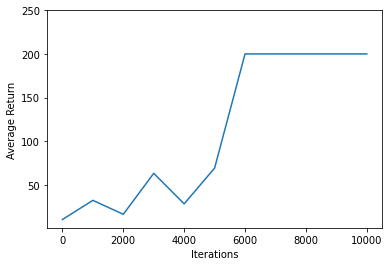

In [28]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [29]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [30]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [31]:
create_policy_eval_video(random_policy, "random-agent")